## Part 3: Environmental Benifits of Transit

Assume that each driveway has two cars and that all people work in downtown Kingston, how many new
bus routes are needed to make people leave their cars at home? How much would that reduce the gas
emissions (make your own reasonable assumptions)?


### Calculating commuting distance

Assumptions:

1. All people work in downtown Kingston, for simplicity the downtown tranfer station is taken as the destination coorditates for every person's commute.

2. Each driveway has two cars, driveway coorditates are taken from the "driveways" dataset from the City of Kingston


In [210]:
import pandas as pd
from geopy.distance import distance
import missingno as miss
%cd "C:\Users\mcunningham\Documents\PythonProjects\CISC451\Datasets"

C:\Users\mcunningham\Documents\PythonProjects\CISC451\Datasets


In [211]:
# load points of interest dataset
df = pd.read_csv("point-of-interest.csv", ';')
# Get the downtown transfer point's coordinates
downtown_point = df.loc[df['NAME'] == 'DOWNTOWN TRANSFER POINT', 'geo_point_2d'].values[0]
# convert to a tuple of floats
downtown_lon = float(downtown_point.split(',')[0])
downtown_lat = float(downtown_point.split(',')[1])
downtown_coords = (downtown_lon, downtown_lat)
print(downtown_coords)

(44.2310329063, -76.4845381585)


#### Cleaning the driveway dataset

In [212]:
df = pd.read_csv("driveways.csv", ';')
df.isna().sum()


﻿&quot;STATUS&quot;       2
MATERIAL        1
GeoJSON         3
geo_point_2d    3
dtype: int64

We only want active driveways so we filter for those, and then check for any missing values.

In [213]:
df.drop(df[df[df.keys()[0]] != 'ACTIVE'].index, inplace=True)
df.isna().sum()

﻿&quot;STATUS&quot;       0
MATERIAL        0
GeoJSON         3
geo_point_2d    3
dtype: int64

Since there are only three missing values, we decided to drop the rows

In [214]:
df.dropna(inplace=True)
df.isna().sum()

﻿&quot;STATUS&quot;       0
MATERIAL        0
GeoJSON         0
geo_point_2d    0
dtype: int64

Now we convert the "geo_point_2d" column into a list of tuples containing latitude and longitude coordinates of type float.

In [215]:
driveway_coords = df['geo_point_2d'].str.split(',', expand=True).astype(float).rename(columns={0:'Latitude', 1:'Longitude'})
driveway_coords_tuples = zip(driveway_coords['Latitude'], driveway_coords['Longitude'])
print(len(driveway_coords))

45296


Calculate the total distance from each driveway to the downtown of Kingston (in km).

In [216]:
total_distance = 0
for driveway in driveway_coords_tuples:
    total_distance += distance(driveway, downtown_coords).km
print(total_distance)

309684.95809977344


Now we calculate which neighbourhood each driveway is located within.

In [217]:
from turfpy.measurement import boolean_point_in_polygon, centroid, distance
from geojson import Point, MultiPolygon, Polygon, Feature, load
from pprint import pprint
%cd "C:\Users\mcunningham\Documents\PythonProjects\CISC451"

C:\Users\mcunningham\Documents\PythonProjects\CISC451


In [218]:
with open("A1_geo\\neighbourhoods.geojson") as n:
    neighbourhoods = load(n)
dt = Feature(geometry=Point((downtown_coords[1], downtown_coords[0])))
for neighbourhood in neighbourhoods['features']:
    # neighbourhood['polygon'] = Feature(geometry=Polygon(neighbourhood.geometry.coordinates))
    # Create driveway_count key in neighbourhoods dict
    neighbourhood['properties']['driveway_count'] = 0
    neighbourhood['properties']['commuter_distance'] = 0
    neighbourhood['properties']['centroid'] = centroid(neighbourhood)
    neighbourhood['properties']['distance_to_downtown'] = distance(neighbourhood['properties']['centroid'], dt)
    print(f"{neighbourhood['properties']['name']}\nCentroid: {neighbourhood['properties']['centroid']}\nDistance: {neighbourhood['properties']['distance_to_downtown']}")

Marker&#39;s Acres
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.464708, 44.273464], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 4.975449323853646
Polson Park
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.532533, 44.234207], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 3.8401480015384615
Reddendale
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.564105, 44.21394], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 6.619166762025739
Rideau Heights
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-76.462188, 44.265945], &quot;type&quot;: &quot;Point&quot;}, &quot;properties&quot;: {}, &quot;type&quot;: &quot;Feature&quot;}
Distance: 4.270759875122126
Williamsville
Centroid: {&quot;geometry&quot;: {&quot;coordinates&quot;: [-

In [219]:

for driveway in zip(driveway_coords['Longitude'], driveway_coords['Latitude']):
    # convert tuple to a geojson feature
    driveway = Feature(geometry=Point(driveway))
    # Check if driveway is located within each neighbourhood
    for neighbourhood in neighbourhoods['features']:
        if boolean_point_in_polygon(driveway, neighbourhood):
            # Increment driveway count for the neighbourhood
            neighbourhood['properties']['driveway_count'] += 1
            # Add up all the car milage for each driveway in the neighbourhood
            # (2 cars per driveway)
            neighbourhood['properties']['commuter_distance'] += 2 * distance(driveway, dt)
            break

Bus capacity taken from https://www.dimensions.com/element/city-transit-buses

In [257]:
from math import ceil
bus_seat_cap = 29
bus_total_cap = 76
# initiate lists for creating a dataframe
names = []
driveway_count = []
busses_required = []
commuting_distance = []
tansit_distance = []
for neighbourhood in neighbourhoods['features']:
    prop = neighbourhood['properties']
    prop['busses_required'] = ceil(prop['driveway_count'] * 2 / bus_total_cap)
    prop['transit_stand_distance'] = prop['busses_required'] * prop['distance_to_downtown']
    print(
        f"{prop['name']}\n"
        f"Driveways:\t\t\t\t{prop['driveway_count']}\n"
        f"Commute Distance (km):\t\t\t{prop['commuter_distance']}\n"
        f"Transit Distance All Seated (km):\t{prop['transit_seat_distance']}\n"
        f"Transit Distance Standing room (km):\t{prop['transit_stand_distance']}\n"
    )
    names.append(prop['name'])
    busses_required.append(prop['busses_required'])
    driveway_count.append(prop['driveway_count'])
    commuting_distance.append(prop['commuter_distance'])
    tansit_distance.append(prop['transit_stand_distance'])

Marker&#39;s Acres
Driveways:				1080
Commute Distance (km):			9266.305403947135
Transit Distance All Seated (km):	373.1586992890235
Transit Distance Standing room (km):	144.28803039175574

Polson Park
Driveways:				398
Commute Distance (km):			2891.6648998106134
Transit Distance All Seated (km):	107.52414404307692
Transit Distance Standing room (km):	42.24162801692307

Reddendale
Driveways:				592
Commute Distance (km):			8343.371726977526
Transit Distance All Seated (km):	271.38583724305533
Transit Distance Standing room (km):	105.90666819241183

Rideau Heights
Driveways:				1363
Commute Distance (km):			8712.914112038177
Transit Distance All Seated (km):	401.4514282614798
Transit Distance Standing room (km):	153.74735550439652

Williamsville
Driveways:				453
Commute Distance (km):			1288.9364293787655
Transit Distance All Seated (km):	46.60318679109621
Transit Distance Standing room (km):	17.47619504666108

Alwington
Driveways:				425
Commute Distance (km):			1662.4136656093854
Tra

Create Datafrsme and plot results.

**Assumptions:**

1. Fuel ifficiency of the average car is 8.9L/100km (11.286 km/l) ()

2. Fuel efficiency of a city bus is 3.26 mpg (1.4878 km/l) (https://www.bts.gov/content/bus-fuel-consumption-and-travel-metric)

In [258]:
car_efficiency = 11.286
bus_efficiency = 1.4878
commute_df = pd.DataFrame({'Neighbourhood': names, 'Number of Driveways': driveway_count, 'Busses Required': busses_required, 'Commuting Distance': commuting_distance, 'Transit Distance': tansit_distance})
commute_df['Commute Consumption'] = commute_df['Commuting Distance']/car_efficiency
commute_df['Transit Consumption'] = commute_df['Transit Distance']/car_efficiency
commute_df.head()

,Neighbourhood,Number of Driveways,Busses Required,Commuting Distance,Transit Distance,Commute Consumption,Transit Consumption
0,Marker's Acres,1080,29,9266.305404,144.288030,821.044250,12.784692
1,Polson Park,398,11,2891.664900,42.241628,256.216986,3.742834
2,Reddendale,592,16,8343.371727,105.906668,739.267387,9.383898
3,Rideau Heights,1363,36,8712.914112,153.747356,772.010820,13.622839
4,Williamsville,453,12,1288.936429,17.476195,114.206666,1.548484


&lt;AxesSubplot:xlabel=&#39;Neighbourhood&#39;&gt;

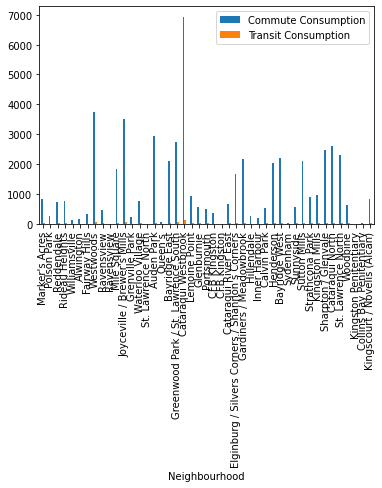

In [261]:
commute_df[['Neighbourhood', 'Commute Consumption', 'Transit Consumption']].plot.bar(x='Neighbourhood')

&lt;AxesSubplot:ylabel=&#39;None&#39;&gt;

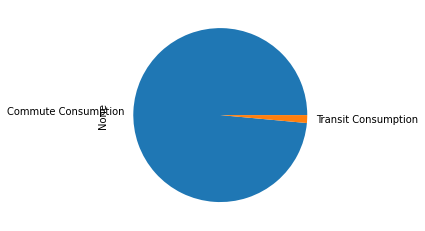

In [262]:
commute_df[['Commute Consumption', 'Transit Consumption']].sum().plot.pie()

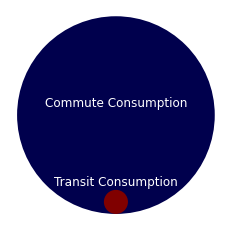

In [284]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection


def nested_circles(data, labels=None, c=None, ax=None, 
                   cmap=None, norm=None, textkw={}):
    ax = ax or plt.gca()
    data = np.array(data)
    R = np.sqrt(data/data.max())
    p = [plt.Circle((0,r), radius=r) for r in R[::-1]]
    arr = data[::-1] if c is None else np.array(c[::-1])
    col = PatchCollection(p, cmap=cmap, norm=norm, array=arr)

    ax.add_collection(col)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.autoscale()

    if labels is not None:
        kw = dict(color="white", va="center", ha="center")
        kw.update(textkw)
        ax.text(0, R[0] + 0.2, labels[0], **kw)
        for i in range(1, len(R)):
            ax.text(0, R[i]+R[i-1], labels[i], **kw)
    return col
data = [commute_df['Transit Consumption'].sum(), commute_df['Commute Consumption'].sum()]
labels = ['Transit Consumption', 'Commute Consumption']
nested_circles(data, labels=labels, cmap="seismic_r", textkw=dict(fontsize=12))
plt.show()